In [40]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [17]:
names = ['z', 'p4', 'p8', 'p12', 'f', 'err4', 'err8', 'err12']
v = {}
for name in names:
    v[name] = loadtxt('../data/' + name + '.txt')

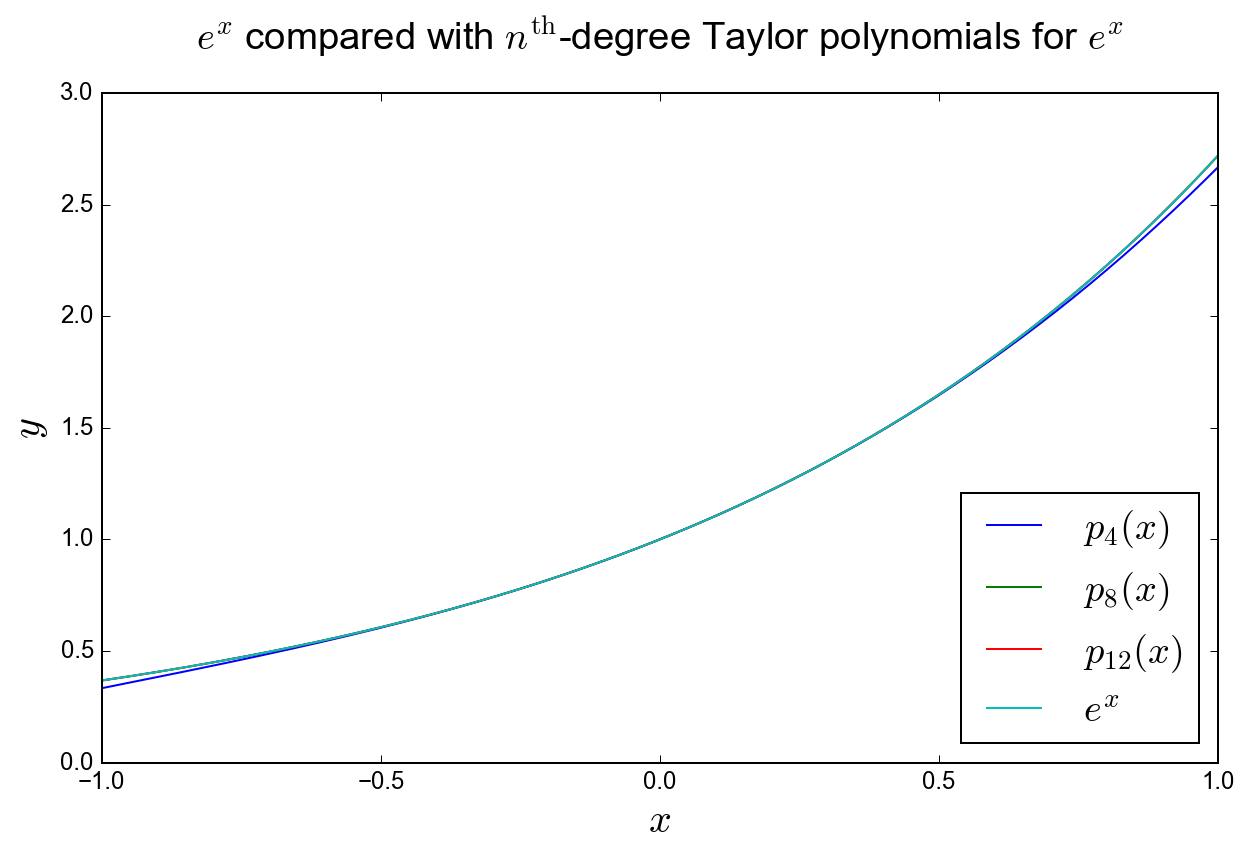

In [54]:
# Plot ex, p4(x), p8(x) and p12(x) 
# in the same figure window with different colors. 
# Add a legend, axis labels and title to the plot.

pylab.plot(v['z'], v['p4'], 
           v['z'], v['p8'], 
           v['z'], v['p12'],
           v['z'], v['f'])

pylab.legend(('$p_{4}(x)$',
              '$p_{8}(x)$',
              '$p_{12}(x)$',
              '$e^x$'), loc=4)

pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.title('$e^x$ compared with $n^{\mathrm{th}}$ degree Taylor polynomials for $e^x$', y=1.05)

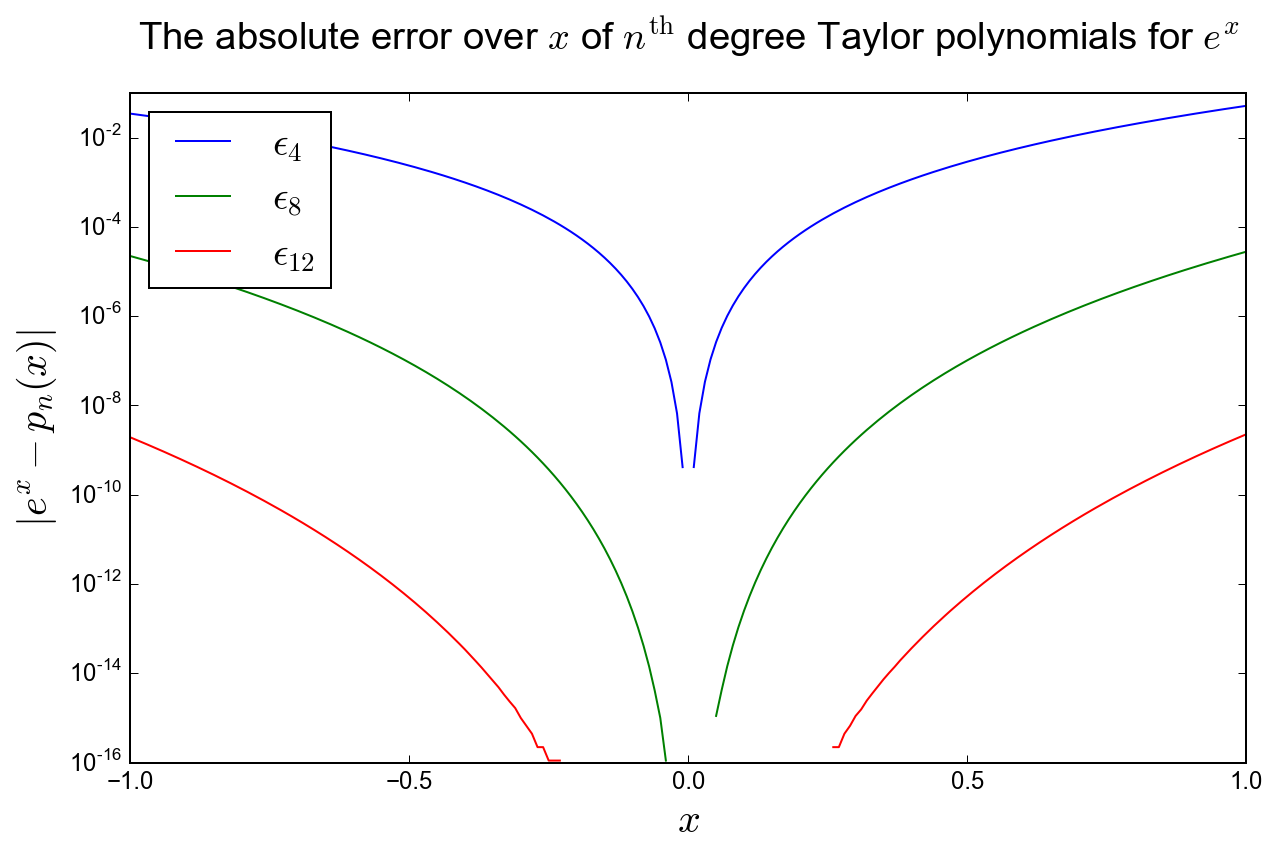

In [55]:
# Plot |e^x−p4(x)|, |e^x −p8(x)| and |e^x−p12(x)| in another 
# figure window using the matplotlib command semilogy, 
# again with a legend, axis labels and a title.

pylab.semilogy(v['z'], v['err4'], 
           v['z'], v['err8'], 
           v['z'], v['err12'])

pylab.legend(('$\epsilon_{4}$',
              '$\epsilon_{8}$',
              '$\epsilon_{12}$'), loc=2)

pylab.xlabel('$x$')
pylab.ylabel('$|e^x-p_n(x)|$')
pylab.title('The absolute error over $x$ of $n^{\mathrm{th}}$ degree Taylor polynomials for $e^x$', y=1.05)